# Loading and Evaluating a Foundation Model


In [1]:
!pip install -q "datasets==2.15.0"
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Import the datasets and transformers packages

splits = ["train", "validation"]

ds = {split: load_dataset("zeroshot/twitter-financial-news-sentiment", split=split) for split in splits}

# Show the dataset 
ds

{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 9543
 }),
 'validation': Dataset({
     features: ['text', 'label'],
     num_rows: 2388
 })}

In [4]:
train_ds = ds["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9543
})

In [5]:
sentiments = {
    0: "Bearish",
    1: "Bullish",
    2: "Neutral"
}

sentiments_reversed = {
    "Bearish": 0,
    "Bullish": 1,
    "Neutral": 2
}

In [6]:
sentiments

{0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

In [7]:
len(train_ds)

9543

In [8]:
train_ds[0]

{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [11]:
train_ds[:5]

{'text': ['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
  '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3',
  '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb',
  '$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N',
  '$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB'],
 'label': [0, 0, 0, 0, 0]}

In [12]:
ds["train"].set_format(type='pandas')

# Visualizing the Dataset

In [13]:
df = ds["train"][:]
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [14]:
# Transformation function to apply the mapping with integer labels
def label_to_sentiment(label):
    # Direct mapping using integer label
    return sentiments.get(label, "Unknown")  # "Unknown" is a default if label not found

# Adding a new column with sentiment names
df['label_name'] = df['label'].apply(label_to_sentiment)

df.head()

,text,label,label_name
0,$BYND - JPMorgan reels in expectations on Beyo...,0,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,0,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,0,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,Bearish


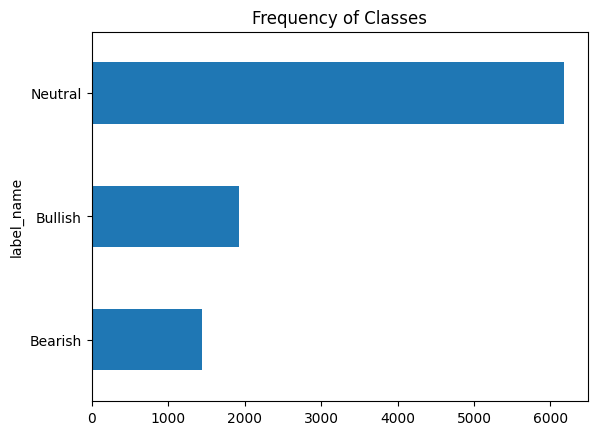

In [15]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

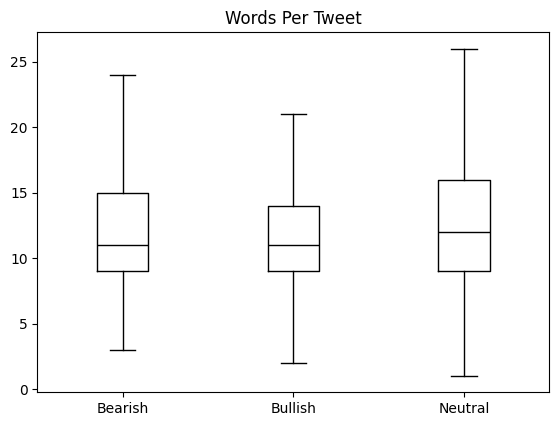

In [16]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
              showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
ds["train"].reset_format()

# Preproces the Dataset

In [18]:
from transformers import AutoTokenizer 
model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)


tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds[split].map(tokenize, batched=True)


# Load and set up the model

In [19]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label=sentiments,  # For converting predictions to strings
    label2id=sentiments_reversed,
)

# Freeze all the parameters of the base model
for param in model.base_model.parameters():
    param.requires_grad = False

model.classifier

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=3, bias=True)

In [20]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Training the Model

In [21]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}



trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/sentiment_analysis_1",
        learning_rate=2e-3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("./data/sentiment_analysis_1/model_1")
model1_path = "./data/sentiment_analysis_1/model_1"

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.662600,0.566198,0.775126


Checkpoint destination directory ./data/sentiment_analysis_1/checkpoint-2386 already exists and is non-empty.Saving will proceed but saved results may be invalid.


# Model Evaluation

In [22]:
trainer.evaluate()

{'eval_loss': 0.5661982297897339,
 'eval_accuracy': 0.7751256281407035,
 'eval_runtime': 40.3981,
 'eval_samples_per_second': 59.112,
 'eval_steps_per_second': 14.778,
 'epoch': 1.0}

In [23]:
import pandas as pd

df = pd.DataFrame(tokenized_ds["validation"])
df = df[["text", "label"]]

# Replace <br /> tags in the text with spaces
df["text"] = df["text"].str.replace("<br />", " ")

# Add the model predictions to the dataframe
predictions = trainer.predict(tokenized_ds["validation"])
df["predicted_label"] = np.argmax(predictions[0], axis=1)


In [24]:
df.tail(10)

,text,label,predicted_label
2378,Lithium Americas and Gulf Resources among Ener...,2,2
2379,Marvell Technology (MRVL) Gains As Market Dips...,2,1
2380,Peloton Interactive among consumer gainers; Py...,2,2
2381,Sarepta Therapeutics leads healthcare gainers;...,2,2
2382,Stabilis Energy and Yuma Energy among Energy/M...,2,2
2383,Stocks making the biggest moves midday: TD Ame...,2,1
2384,Stocks making the biggest moves premarket: Fit...,2,1
2385,Stocks making the biggest moves premarket: Hom...,2,1
2386,Stocks making the biggest moves premarket: TD ...,2,2
2387,"TCO, NNVC, GPOR and JE among midday movers",2,2


In [25]:
# Show full cell output
pd.set_option("display.max_colwidth", None)

df[df["label"] != df["predicted_label"]].head(25)

,text,label,predicted_label
0,$ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5,0,2
1,"$DELL $HPE - Dell, HPE targets trimmed on compute headwinds https://t.co/YRUHZw7cYl",0,1
2,$PRTY - Moody's turns negative on Party City https://t.co/MBD5TFGC4P,0,2
4,$SITC: Compass Point cuts to Sell,0,1
5,$TAP - Barclays cools on Molson Coors https://t.co/FJFsZWJHuH,0,2
6,$TAP: Barclays cuts to Equal Weight,0,1
7,"Analysts Eviscerate Musk's Cybertruck: ""0% Of Responses Felt It Will Be A Success"" https://t.co/2NTzeZea4G",0,1
9,BTIG points to breakfast pressure for Dunkin' Brands,0,1
12,Downgrades 4/7: $AAN $BDN $BECN $BTE $CDEV $CHK $COOP $CPE $CVA $DAN $DOC $DRH $EPR $ESRT $ETM $FAST $FBM $GM $GMS… https://t.co/CMXD50oQxI,0,2
13,Goldman pulls Progressive from Goldman's conviction list; shares -2.7%,0,1


In [26]:
matches_count = (df['label'] == df['predicted_label']).sum()

print(f"Number of matching rows: {matches_count}")

Number of matching rows: 1851


In [27]:
1855/2386

0.7774518021793797

## Performing Parameter-Efficient Fine-Tuning

In [28]:
import os
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from peft import PeftConfig, get_peft_model, PeftModel
from peft import LoraConfig, TaskType

class CustomTrainer(Trainer):
    def _save_checkpoint(self, model, trial, metrics=None):
        checkpoint_folder = f"checkpoint-{self.state.global_step}"
        run_dir = self.args.output_dir
        output_dir = os.path.join(run_dir, checkpoint_folder)
        PeftModel.save_pretrained(model, output_dir)

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=sentiments,
    label2id=sentiments_reversed,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define the compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["classifier"],  
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

# Apply LoRA to the model
model_ft = get_peft_model(model, lora_config)

# Training arguments
training_args = TrainingArguments(
    output_dir="./data/sentiment_analysis",
    learning_rate=2e-3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",  # Directory to save logs
    logging_steps=100,  # Log every 100 steps
    save_total_limit=3,  # Save the last 3 checkpoints
)

# Initialize the CustomTrainer
trainer_ft = CustomTrainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train the model with LoRA
trainer_ft.train()

# Save the final trained model
PeftModel.save_pretrained(model_ft, "./data/sentiment_analysis/trained_model_fine_tuned")
tokenizer.save_pretrained("./data/sentiment_analysis/trained_model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.717500,0.594613,0.750000
2,0.589000,0.557057,0.787688
3,0.551000,0.536155,0.797320
4,0.606800,0.517205,0.806114


('./data/sentiment_analysis/trained_model/tokenizer_config.json',
 './data/sentiment_analysis/trained_model/special_tokens_map.json',
 './data/sentiment_analysis/trained_model/vocab.txt',
 './data/sentiment_analysis/trained_model/added_tokens.json',
 './data/sentiment_analysis/trained_model/tokenizer.json')

In [29]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    "./data/sentiment_analysis_1/model_1",
    num_labels=3
)

In [30]:
model2 = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Specify the correct number of labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model2 = PeftModel.from_pretrained(model2, "./data/sentiment_analysis/trained_model_fine_tuned")

In [32]:
trainer1 = Trainer(
    model=model1,
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
eval_results1 = trainer1.evaluate()
print("Model 1 Evaluation Results:", eval_results1)

Model 1 Evaluation Results: {'eval_loss': 0.5661981701850891, 'eval_accuracy': 0.7751256281407035, 'eval_runtime': 38.3999, 'eval_samples_per_second': 62.188, 'eval_steps_per_second': 7.786}


In [33]:
trainer2 = Trainer(
    model=model2,
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
eval_results2 = trainer2.evaluate()
print("Model 2 Evaluation Results:", eval_results2)

Model 2 Evaluation Results: {'eval_loss': 0.5172049403190613, 'eval_accuracy': 0.8061139028475712, 'eval_runtime': 38.3737, 'eval_samples_per_second': 62.23, 'eval_steps_per_second': 7.792}


## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [34]:
df = pd.DataFrame(tokenized_ds["validation"])
df = df[["text", "label"]]

# Replace <br /> tags in the text with spaces
df["text"] = df["text"].str.replace("<br />", " ")

# Add the model predictions to the dataframe
predictions = trainer_ft.predict(tokenized_ds["validation"])
df["predicted_label"] = np.argmax(predictions[0], axis=1)

In [35]:
# Show full cell output
pd.set_option("display.max_colwidth", None)

df[df["label"] != df["predicted_label"]].head(25)

,text,label,predicted_label
0,$ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5,0,2
1,"$DELL $HPE - Dell, HPE targets trimmed on compute headwinds https://t.co/YRUHZw7cYl",0,1
5,$TAP - Barclays cools on Molson Coors https://t.co/FJFsZWJHuH,0,2
7,"Analysts Eviscerate Musk's Cybertruck: ""0% Of Responses Felt It Will Be A Success"" https://t.co/2NTzeZea4G",0,2
9,BTIG points to breakfast pressure for Dunkin' Brands,0,1
12,Downgrades 4/7: $AAN $BDN $BECN $BTE $CDEV $CHK $COOP $CPE $CVA $DAN $DOC $DRH $EPR $ESRT $ETM $FAST $FBM $GM $GMS… https://t.co/CMXD50oQxI,0,2
13,Goldman pulls Progressive from Goldman's conviction list; shares -2.7%,0,1
15,Intelsat cut to Market Perform at Raymond James,0,2
22,Novus Therapeutics stock price target cut to $2.50 from $3.75 at Ascendiant Capital,0,1
28,WWE stock price target cut to $58 from $92 at MKM Partners,0,2


In [36]:
matches_count = (df['label'] == df['predicted_label']).sum()

print(f"Number of matching rows: {matches_count}")

Number of matching rows: 1925
